# E-commerce Data Preparation

## Table of Contents

1. Introduction
2. Data Loading
3. Data Cleaning
4. Basic Exploratory Data Analysis
5. Conclusion

### Introduction

This project analyzes the Olist brazilian e-commerce dataset (2016–2018), which contains ~100k orders across multiple tables (orders, items, payments, reviews, customers, geolocation, products). Olist is one of Brazil’s largest marketplaces, connecting small sellers to customers nationwide. 
Note that most interactive exploration and dashboards were built in Tableau, while Python was used for data cleaning, additional eda, and to generate plots that are less convenient in Tableau. 

### Data Loading

Load and examine the initial structure of the datasets required for this analysis.

In [1]:
# Install dependencies
# pip install kagglehub[pandas-datasets]

import unicodedata
import re
import kagglehub
import matplotlib.pyplot as plt # for future plotting if needed
import seaborn as sns
import numpy as np 

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

import pandas as pd
import os
import matplotlib.pyplot as plt
dataset_path = path  # from your previous cell

# loading each dataset
df_customers = pd.read_csv(os.path.join(dataset_path, "olist_customers_dataset.csv"))
df_geolocation = pd.read_csv(os.path.join(dataset_path, "olist_geolocation_dataset.csv"))
df_payments = pd.read_csv(os.path.join(dataset_path, "olist_order_payments_dataset.csv"))
df_products = pd.read_csv(os.path.join(dataset_path, "olist_products_dataset.csv"))
df_sellers = pd.read_csv(os.path.join(dataset_path, "olist_sellers_dataset.csv"))
df_category_translation = pd.read_csv(os.path.join(dataset_path, "product_category_name_translation.csv"))
df_orders = pd.read_csv(os.path.join(dataset_path, "olist_orders_dataset.csv"))
df_reviews = pd.read_csv(os.path.join(dataset_path, "olist_order_reviews_dataset.csv"))
df_items = pd.read_csv(os.path.join(dataset_path, "olist_order_items_dataset.csv"))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/tishaasuncion/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2


We started by pulling the Olist Brazilian E-Commerce dataset from Kaggle and loading all the tables into Pandas. This gives us access to customers, orders, products, payments, reviews, and more. Most of the business questions are tackled in SQL, while Tableau is used for interactive dashboards. Python here is mainly for quick EDA and visuals that aren’t as convenient elsewhere.

In [2]:
# taking a look at all columns for each dataset
tables = {
    "customers": df_customers,
    "geolocation": df_geolocation,
    "payments": df_payments,
    "products": df_products,
    "sellers": df_sellers,
    "category_translation": df_category_translation,
    "orders": df_orders,
    "reviews": df_reviews,
    "order_items": df_items,
}

# printing all column names for each df
for name, df in tables.items():
    print(f"\n--- {name} ({df.shape[0]} rows, {df.shape[1]} cols) ---")
    print(df.columns.tolist())



--- customers (99441 rows, 5 cols) ---
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

--- geolocation (1000163 rows, 5 cols) ---
['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']

--- payments (103886 rows, 5 cols) ---
['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']

--- products (32951 rows, 9 cols) ---
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

--- sellers (3095 rows, 4 cols) ---
['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']

--- category_translation (71 rows, 2 cols) ---
['product_category_name', 'product_category_name_english']

--- orders (99441 rows, 8 cols) ---
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_appro

We printed out the shape and column names for each table. This gave us a quick overview of what information is available in customers, orders, products, payments, and the other datasets.

### Data Cleaning

Here, we will fix category translations, standardize city names, and handle invalid delivery dates so the dataset is consistent for analysis.

In [3]:
# function to strip accents and clean punctuation
def clean_city_name(name):
    if pd.isnull(name):
        return name
    # normalize unicode (remove accents/diacritics)
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('utf-8')
    # set everything to lowercase
    name = name.lower()
    # remove extra whitespace
    name = re.sub(r'\s+', ' ', name).strip()
    # remove punctuation (apostrophes, dots, etc.)
    name = re.sub(r"[^a-z0-9\s]", "", name)
    return name

# apply cleaning directly to geolocation_city
df_geolocation["geolocation_city"] = df_geolocation["geolocation_city"].apply(clean_city_name)

# deduplicate by zip_code_prefix
df_geolocation_clean = df_geolocation.drop_duplicates(subset=["geolocation_zip_code_prefix"]).copy()

# replace original reference
df_geolocation = df_geolocation_clean

In the geolocation table, I noticed that some city names were repeated with different spellings or accents. To fix this, we’ll clean the city names (remove accents and punctuation, make everything lowercase) and drop duplicate entries by zip code prefix so each location is consistent.

In [4]:
# making sure our function above worked
unique_cities_raw = pd.Series(df_geolocation["geolocation_city"].unique())
unique_cities_sorted = unique_cities_raw.sort_values().reset_index(drop=True)
unique_cities_sorted.head(100)

0         abadia de goias
1     abadia dos dourados
2               abadiania
3                  abaete
4              abaetetuba
             ...         
95               aiuruoca
96              ajuricaba
97                 alagoa
98          alagoa grande
99            alagoa nova
Length: 100, dtype: object

Sorting and previewing them confirms that accents and duplicates were removed as expected.

In [5]:
# merge products with translation df 
products_with_translation = df_products.merge(
    df_category_translation,
    on="product_category_name",
    how="left"
)

# find categories with missing English translation
missing_translations = products_with_translation[
    products_with_translation["product_category_name_english"].isna()
]["product_category_name"].unique()

print(len(missing_translations))
print(missing_translations)

3
[nan 'pc_gamer' 'portateis_cozinha_e_preparadores_de_alimentos']


For product data, we merged the products table with the category translation file to add English category names. After merging, we checked which categories are still missing translations so we can handle them separately. These categories turned out to be gaming pcs and kitchen appliances.

In [6]:
# keep original df_products intact
df_products_clean = df_products.copy()

# translation is enrichment → separate df
df_products_with_translation = df_products_clean.merge(
    df_category_translation,
    on="product_category_name",
    how="left"
)

# fill missing translations manually 
manual_translations = {
    "pc_gamer": "gaming_pc",
    "portateis_cozinha_e_preparadores_de_alimentos": "kitchen_appliances"
}

df_products_with_translation["product_category_name_english"] = (
    df_products_with_translation.apply(
        lambda row: manual_translations.get(
            row["product_category_name"], row["product_category_name_english"]
        ),
        axis=1
    )
    .fillna("unknown_category")
)

We merged products with the translation file, manually fixed a couple of missing names, and labeled the rest as “unknown_category.” This ensured that every product had a consistent category name in English for analysis and visualization.

In [7]:
# checking our work and making sure it's correct
df_products_with_translation[["product_category_name", "product_category_name_english"]].drop_duplicates().tail(10)

,product_category_name,product_category_name_english
1628,pc_gamer,gaming_pc
3123,moveis_quarto,furniture_bedroom
3195,cine_foto,cine_photo
3825,fraldas_higiene,diapers_and_hygiene
4550,flores,flowers
4713,casa_conforto_2,home_comfort_2
5821,portateis_cozinha_e_preparadores_de_alimentos,kitchen_appliances
6060,seguros_e_servicos,security_and_services
7046,moveis_colchao_e_estofado,furniture_mattress_and_upholstery
18189,cds_dvds_musicais,cds_dvds_musicals


Now, our cleaned categories were applied correctly!

In [8]:
# checking if delivered_customer_date < purchase_timestamp

# convert to datetime (all relevant cols, not just two)
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date"
]
for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col], errors="coerce")

# find invalid rows where delivered date < purchase date
invalid_mask = df_orders["order_delivered_customer_date"] < df_orders["order_purchase_timestamp"]

print(f"found {invalid_mask.sum()} orders with delivered_customer_date < purchase_timestamp")

# set invalid delivered dates to NaT (null datetime)
df_orders.loc[invalid_mask, "order_delivered_customer_date"] = pd.NaT

# check the cleaned columns
df_orders[["order_id", "order_purchase_timestamp", "order_delivered_customer_date"]].head(10)


found 0 orders with delivered_customer_date < purchase_timestamp


,order_id,order_purchase_timestamp,order_delivered_customer_date
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02
5,a4591c265e18cb1dcee52889e2d8acc3,2017-07-09 21:57:05,2017-07-26 10:57:55
6,136cce7faa42fdb2cefd53fdc79a6098,2017-04-11 12:22:08,NaT
7,6514b8ad8028c9f2cc2374ded245783f,2017-05-16 13:10:30,2017-05-26 12:55:51
8,76c6e866289321a7c93b82b54852dc33,2017-01-23 18:29:09,2017-02-02 14:08:10
9,e69bfb5eb88e0ed6a785585b27e16dbf,2017-07-29 11:55:02,2017-08-16 17:14:30


Now, we converted purchase and delivery dates into datetime format, calculated delivery days for each order, and flagged any cases where the delivery date was earlier than the purchase date. Those invalid values were set to null so they wouldn’t skew analysis.

In [9]:
# merging all dfs according to the given schema
# orders + customers
df_merged = df_orders.merge(df_customers, on="customer_id", how="left")

# add geolocation (on zip prefix)
df_merged = df_merged.merge(df_geolocation, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")

# add order items
df_merged = df_merged.merge(df_items, on="order_id", how="left")

# add products (with cleaned translation)
df_merged = df_merged.merge(
    df_products.merge(df_category_translation, on="product_category_name", how="left")
               .assign(product_category_name_english=lambda d: d.apply(
                   lambda row: {
                       "pc_gamer": "gaming_pc",
                       "portateis_cozinha_e_preparadores_de_alimentos": "kitchen_appliances"
                   }.get(row["product_category_name"], row["product_category_name_english"]),
                   axis=1
               ).fillna("unknown_category")),
    on="product_id", how="left"
)

# add sellers
df_merged = df_merged.merge(df_sellers, on="seller_id", how="left")

# add payments
df_merged = df_merged.merge(df_payments, on="order_id", how="left").fillna(0)

# add reviews
df_merged = df_merged.merge(df_reviews[["order_id", "review_score"]], on="order_id", how="left")

Using the schema givem, we merged all of the datasets into one master table. 

In [10]:
# checking the shape of our dataframe
print(df_merged.shape)
df_merged.isnull().sum()

(119143, 40)


order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date       0
order_delivered_customer_date      0
order_estimated_delivery_date      0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
geolocation_zip_code_prefix        0
geolocation_lat                    0
geolocation_lng                    0
geolocation_city                   0
geolocation_state                  0
order_item_id                      0
product_id                         0
seller_id                          0
shipping_limit_date                0
price                              0
freight_value                      0
product_category_name              0
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
p

We see that we have some null values.  This gave us a sense of how complete the data was after joining all the tables and helped us spot where cleaning might still be needed. 

### Exploratory Data Analysis

Here, we will calculate monthly metrics by summing price and freight for each order, the grouping by year and month.

In [11]:
# total sales per order
order_sales = (
    df_items.assign(item_total=lambda d: d["price"] + d["freight_value"])
            .groupby("order_id", as_index=False)["item_total"].sum()
            .rename(columns={"item_total": "order_sales"})
)

# attach purchase timestamp
order_sales = order_sales.merge(
    df_orders[["order_id", "order_purchase_timestamp"]],
    on="order_id", how="left"
)

# setting time columns into datetime
order_sales["order_purchase_timestamp"] = pd.to_datetime(order_sales["order_purchase_timestamp"])
order_sales["year"] = order_sales["order_purchase_timestamp"].dt.year
order_sales["month"] = order_sales["order_purchase_timestamp"].dt.month

# monthly totals
monthly = (
    order_sales.groupby(["year","month"])
    .agg(total_sales=("order_sales","sum"),
         total_orders=("order_id","nunique"))
    .reset_index()
)
monthly["aov"] = monthly["total_sales"] / monthly["total_orders"]

# month labels
months_lbl = ["jan","feb","mar","apr","may","jun",
              "jul","aug","sep","oct","nov","dec"]

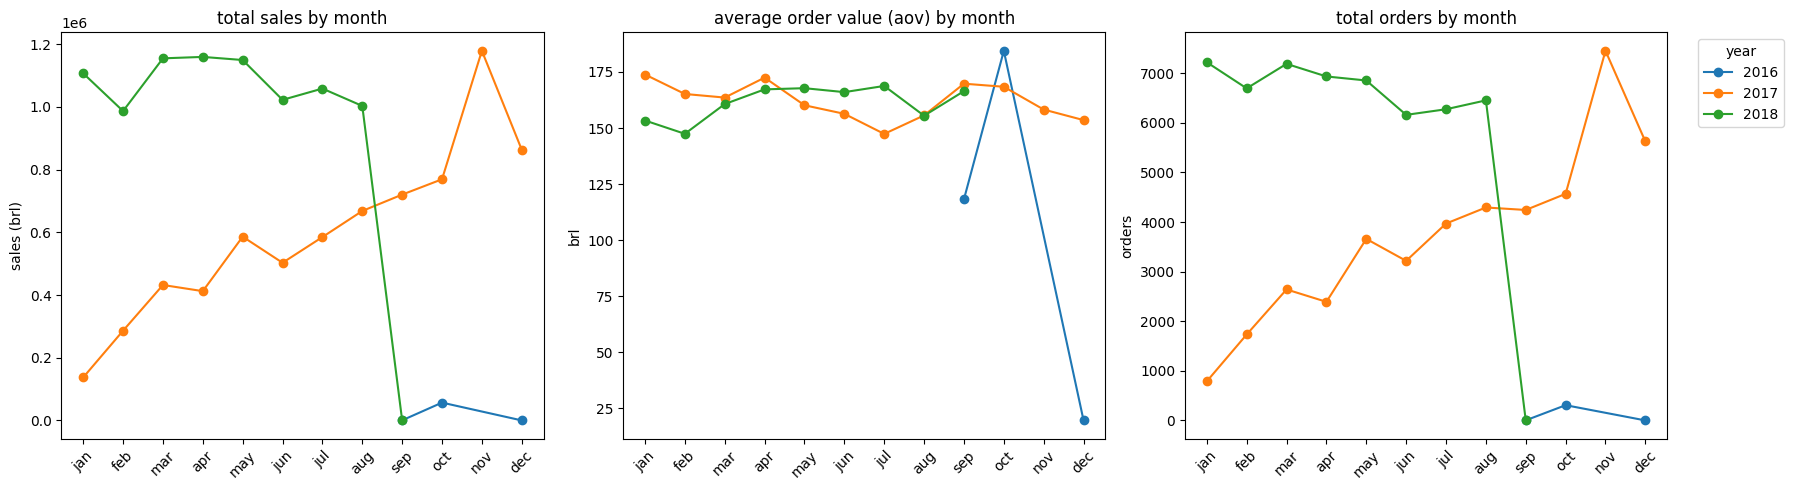

In [12]:
# plot 3 side by side
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=True)

# total sales
for y, grp in monthly.groupby("year"):
    axes[0].plot(grp["month"], grp["total_sales"], marker = "o", label = str(y))
axes[0].set_title("total sales by month")
axes[0].set_xticks(range(1,13), months_lbl, rotation = 45)
axes[0].set_ylabel("sales (brl)")

# aov
for y, grp in monthly.groupby("year"):
    axes[1].plot(grp["month"], grp["aov"], marker = "o", label = str(y))
axes[1].set_title("average order value (aov) by month")
axes[1].set_xticks(range(1,13), months_lbl, rotation = 45)
axes[1].set_ylabel("brl")

# total orders
for y, grp in monthly.groupby("year"):
    axes[2].plot(grp["month"], grp["total_orders"], marker = "o", label = str(y))
axes[2].set_title("total orders by month")
axes[2].set_xticks(range(1,13), months_lbl, rotation = 45)
axes[2].set_ylabel("orders")

# common legend
axes[2].legend(title = "year", bbox_to_anchor = (1.05, 1), loc = "upper left")

plt.tight_layout()
plt.show()

Now, we have plots for monthly sales, AOV, and order counts side by side, with lines split by year.

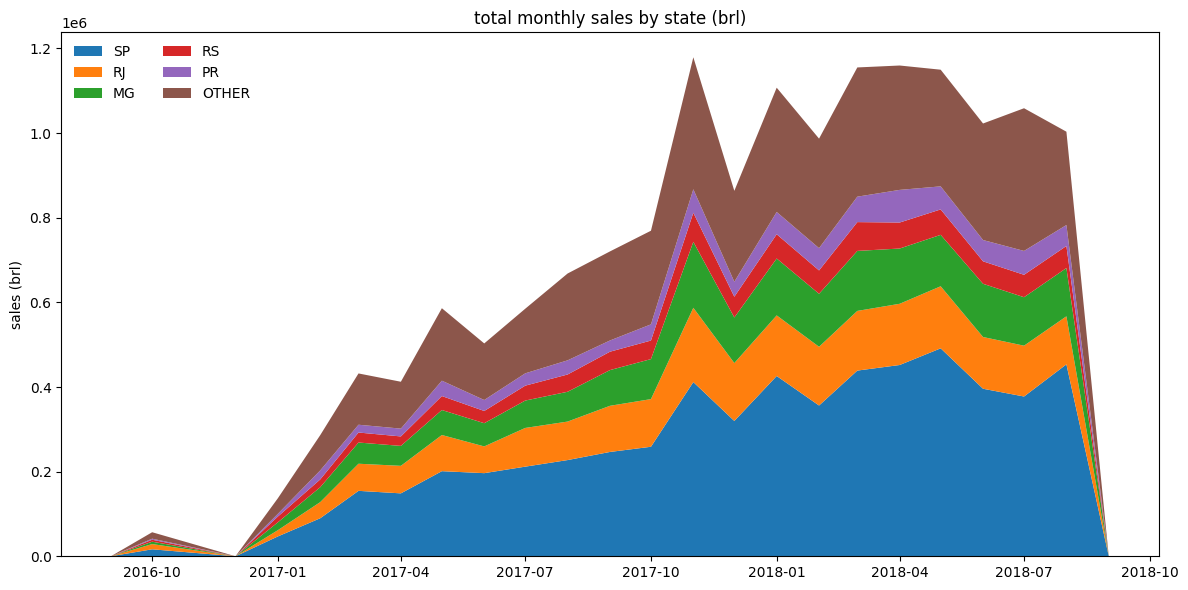

In [13]:
# add customer_id from orders
order_sales = order_sales.merge(
    df_orders[["order_id", "customer_id"]],
    on="order_id",
    how="left"
)

# add customer_state from customers
order_sales = order_sales.merge(
    df_customers[["customer_id", "customer_state"]],
    on="customer_id",
    how="left"
)

# monthly sales by state
state_month_sales = (
    order_sales.groupby(["year", "month", "customer_state"], dropna = False)["order_sales"]
               .sum()
               .reset_index()
)

# pivot wide: each state is a column
pivot_state = (
    state_month_sales.pivot(index = ["year","month"], columns = "customer_state", values = "order_sales")
                    .fillna(0)
                    .sort_index()
)

# turn (year,month) into a datetime index for plotting
pivot_state.index = pd.to_datetime([f"{y}-{m:02d}-01" for y, m in pivot_state.index])
pivot_state = pivot_state.sort_index()

# keep top 5 states by total sales; aggregate the rest into OTHER
top_states = pivot_state.sum().sort_values(ascending = False).head(5).index.tolist()
pivot_state["OTHER"] = pivot_state.drop(columns = top_states, errors = "ignore").sum(axis = 1)
plot_df = pivot_state[top_states + ["OTHER"]]

# stacked area chart
fig, ax = plt.subplots(figsize = (12,6))
ax.stackplot(plot_df.index, plot_df.T, labels = plot_df.columns)
ax.set_title("total monthly sales by state (brl)")
ax.set_ylabel("sales (brl)")
ax.legend(loc="upper left", ncols = 2, frameon = False)
plt.tight_layout()
plt.show()

Here, we broke down monthly sales by customer state and plotted them as a stacked area chart. We highlighted the top five states and group them all together to prevent crowding. This showed how São Paulo and a few other regions dominated sales, while smaller states collectively still represented a large share.

/var/folders/jv/np5_bs3d67s9dkln3z12p4lw0000gn/T/ipykernel_12439/2850721858.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = orders_by_hour, x="hour", y="order_count", palette="husl")


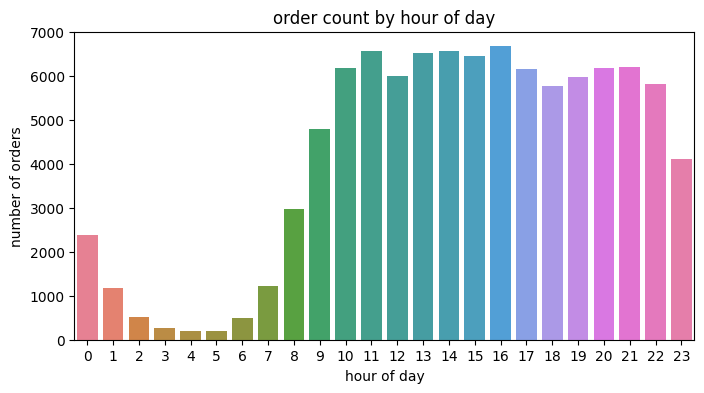

In [14]:
# extract purchase hour into a derived df
orders_by_hour = (
    df_orders.assign(hour = df_orders["order_purchase_timestamp"].dt.hour)
             .groupby("hour")["order_id"]
             .nunique()
             .reset_index(name="order_count")
)

# bar chart
plt.figure(figsize = (8,4))
sns.barplot(data = orders_by_hour, x="hour", y="order_count", palette="husl")
plt.xticks(range(24))
plt.xlabel("hour of day")
plt.ylabel("number of orders")
plt.title("order count by hour of day")
plt.show()

Here, we analyzed when customers placed orders by grouping them by hour of the day. The bar chart showed that activity was lowest overnight, started climbing in the morning, and peaked between late morning and evening.

/var/folders/jv/np5_bs3d67s9dkln3z12p4lw0000gn/T/ipykernel_12439/4184730830.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = aov_by_hour, x = "hour", y = "avg_order_value", palette = "husl")


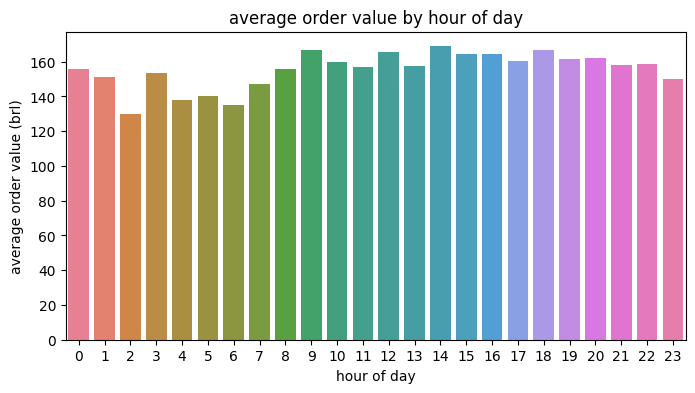

In [15]:
# need sales per order first (reuse order_sales)
order_sales_hour = order_sales.copy()
order_sales_hour["hour"] = order_sales_hour["order_purchase_timestamp"].dt.hour

# avg order value by hour
aov_by_hour = order_sales_hour.groupby("hour")["order_sales"].mean().reset_index(name = "avg_order_value")

# line chart
plt.figure(figsize = (8,4))
sns.barplot(data = aov_by_hour, x = "hour", y = "avg_order_value", palette = "husl")
plt.xticks(range(24))
plt.xlabel("hour of day")
plt.ylabel("average order value (brl)")
plt.title("average order value by hour of day")
plt.show()

Here, we looked at the average order value by hour of the day. The bar chart showed that while order counts peaked during the day, the value of each order stayed relatively steady, with small bumps in the morning and early evening.

In [16]:
# ensure datetime
df_orders["order_purchase_timestamp"] = pd.to_datetime(df_orders["order_purchase_timestamp"])

# derive weekday info only in a temp df
orders_with_sales = order_sales.merge(
    df_orders[["order_id","order_purchase_timestamp"]],
    on="order_id", how="left"
)

orders_with_sales["weekday_num"] = orders_with_sales["order_purchase_timestamp_x"].dt.weekday
orders_with_sales["weekday_name"] = orders_with_sales["order_purchase_timestamp_x"].dt.day_name()

# aggregate sales by weekday
sales_by_day = (
    orders_with_sales.groupby(["weekday_num","weekday_name"])["order_sales"].sum()
    .reset_index()
    .sort_values("weekday_num")
)

# reindex to Sunday → Saturday
day_order = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
sales_by_day["weekday_name"] = pd.Categorical(sales_by_day["weekday_name"], categories=day_order, ordered=True)
sales_by_day = sales_by_day.sort_values("weekday_name")

/var/folders/jv/np5_bs3d67s9dkln3z12p4lw0000gn/T/ipykernel_12439/1238831381.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = sales_by_day, x = "weekday_name", y = "order_sales", palette = "husl")


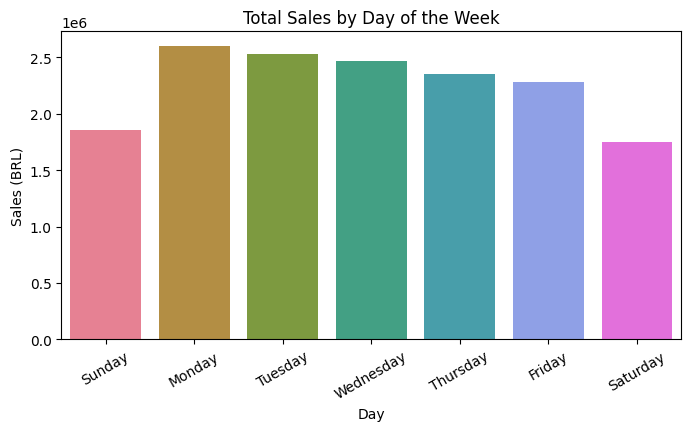

In [17]:
# plot
plt.figure(figsize = (8,4))
sns.barplot(data = sales_by_day, x = "weekday_name", y = "order_sales", palette = "husl")
plt.title("Total Sales by Day of the Week")
plt.xlabel("Day")
plt.ylabel("Sales (BRL)")
plt.xticks(rotation = 30)
plt.show()

Sales were the highest on Mondays, slightly above Tuesday and Wednesday. However, there is a gradual decline through the week. Weekends dipped sharply, with Sunday and Saturday had the lowest sales overall. 

So customers were most active at the start of the week and the least active on weekends.

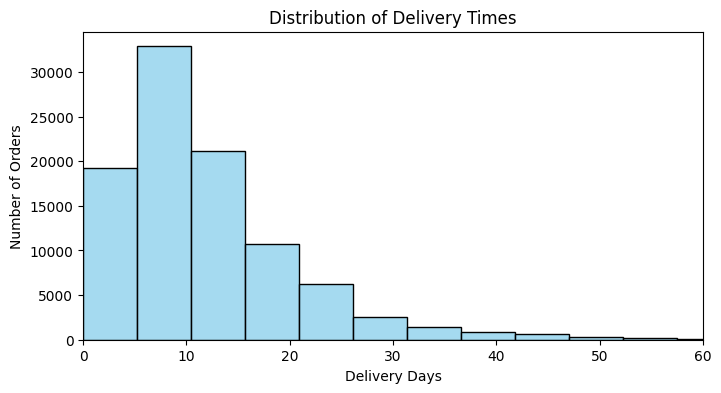

In [ ]:
# calculating delivery days
delivery_days = (
    df_orders["order_delivered_customer_date"] - df_orders["order_purchase_timestamp"]
).dt.days.dropna()

# plot
plt.figure(figsize = (8,4))
sns.histplot(delivery_days, bins=40, kde=False, color="skyblue")
plt.xlabel("Delivery Days")
plt.ylabel("Number of Orders")
plt.title("Distribution of Delivery Times")
plt.xlim(0,60)  # cap at 60 since a few outliers go very high
plt.show()

Delivery times are usually between within 15 days. There are still some deliveries towards 40-60 days. Hence, the bulk of customers received their orders within two weeks but some still experienced longer waits.

## Conclusion

Python was mainly used for cleaning and our introductory exploratory analysis. It helped standardize city names, fix product categories, and handle invalid delivery dates. On the exploratory side, Python provided quick checks like sales trends by month, order activity by hour and weekday, state-level sales, and delivery time distributions. These steps made the data consistent and gave an early look at key patterns before moving into deeper analysis with other tools.

Full conclusion on the README.md file.

In [ ]:
# import os

# set desktop path
# desktop_path = os.path.expanduser("~/Desktop/olist_export")
# os.makedirs(desktop_path, exist_ok=True)

# export each dataframe to CSV
# df_customers.to_csv(os.path.join(desktop_path, "olist_customers_dataset.csv"), index=False)
# df_geolocation.to_csv(os.path.join(desktop_path, "olist_geolocation_dataset.csv"), index=False)
# df_payments.to_csv(os.path.join(desktop_path, "olist_order_payments_dataset.csv"), index=False)
# df_products.to_csv(os.path.join(desktop_path, "olist_products_dataset.csv"), index=False)
# df_sellers.to_csv(os.path.join(desktop_path, "olist_sellers_dataset.csv"))
# df_category_translation.to_csv(os.path.join(desktop_path, "product_category_name_translation.csv"), index=False)
# df_orders.to_csv(os.path.join(desktop_path, "olist_orders_dataset.csv"), index=False)
# df_reviews.to_csv(os.path.join(desktop_path, "olist_order_reviews_dataset.csv"), index=False)
# df_items.to_csv(os.path.join(desktop_path, "olist_order_items_dataset.csv"), index=False)
# df_merged.to_csv(os.path.join(desktop_path, "merged.csv"), index=False)